In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns # I love this package!
sns.set_style('white')

import torch

### Loss Trend Check

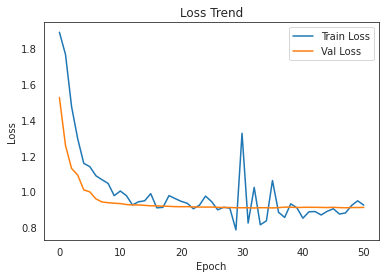

In [2]:
# load check point
model_path = 'checkpoint.pth.tar'
checkpoint = torch.load(model_path)
loss_history_train = checkpoint['loss_history_train']
loss_history_val = checkpoint['loss_history_val']
#loss_train = [np.mean(l) for l in loss_history_train]
loss_train = [float(torch.mean(torch.stack(l))) for l in loss_history_train]
#loss_val = [np.mean(l) for l in loss_history_val]
loss_val = [float(torch.mean(torch.stack(l))) for l in loss_history_val]

plt.plot(loss_train, label = 'Train Loss')
plt.plot(loss_val, label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

### Model performance

In [12]:
model_path = 'model_best.pth.tar'
# calculate outputs for the test data with our best model
output_csv_path = 'pred.csv'
command = ('python pred.py '
           '--img_dir /UCLA-protest/img/test/ '
           '--output_csvpath {csv_path} '
           '--model {model} --batch_size 4 --cuda'
           .format(csv_path = output_csv_path, model = model_path))

            
!{command}

# load prediction
df_pred = pd.read_csv(output_csv_path)
df_pred['imgpath'] = df_pred['imgpath'].apply(os.path.basename)

# load target
test_label_path = '/UCLA-protest/annot_test.txt'
df_target = pd.read_csv(test_label_path, delimiter= '\t')

*** loading model from checkpoint.pth.tar
*** calculating the model output of the images in /UCLA-protest/img/test/
  0%|                                                  | 0/8153 [00:00<?, ?it/s]/ext3/conda/bootcamp/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
8156it [00:31, 255.79it/s]                                                      


#### Binary Variables

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
def plot_roc(attr, target, pred):
    """Plot a ROC curve and show the accuracy score and the AUC"""
    fig, ax = plt.subplots()
    auc = roc_auc_score(target, pred)
    acc = accuracy_score(target, (pred >= 0.5).astype(int))
    fpr, tpr, _ = roc_curve(target, pred)
    plt.plot(fpr, tpr, lw = 2, label = attr.title())
    plt.legend(loc = 4, fontsize = 15)
    plt.title(('ROC Curve for {attr} (Accuracy = {acc:.3f}, AUC = {auc:.3f})'
               .format(attr = attr.title(), acc= acc, auc = auc)),
              fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.show()
    return fig

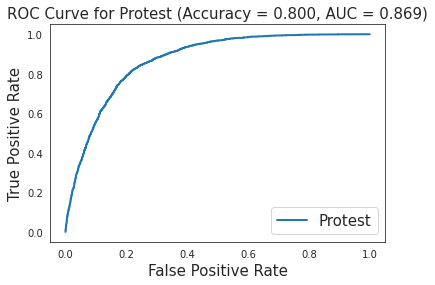

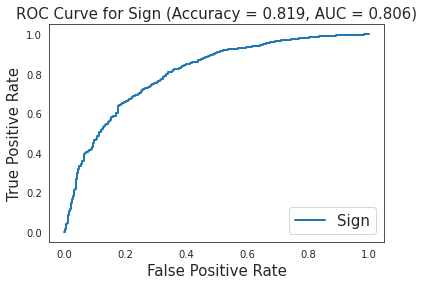

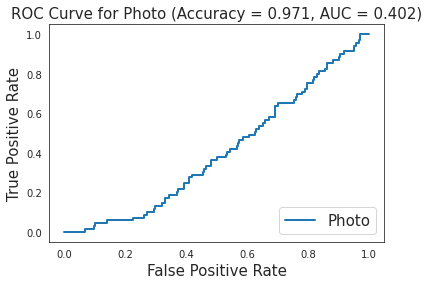

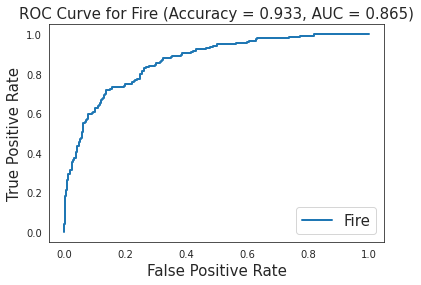

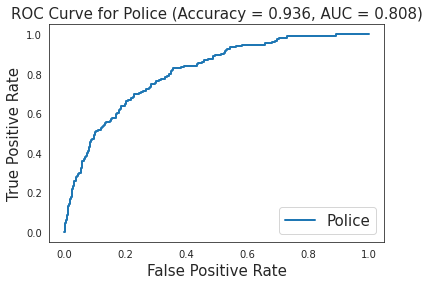

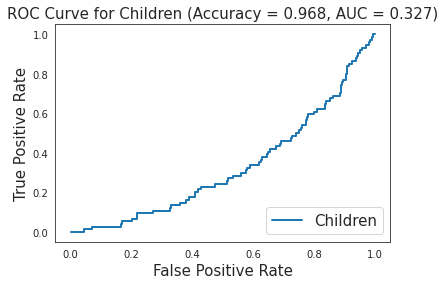

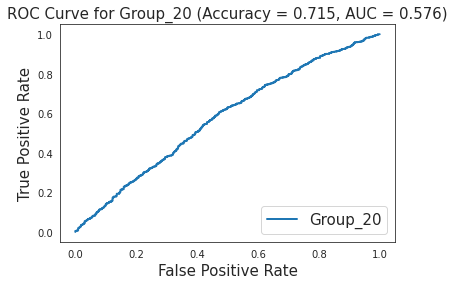

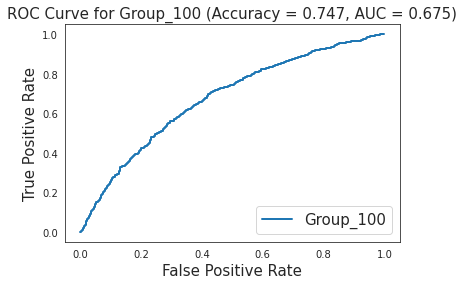

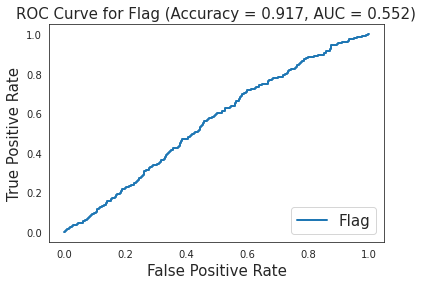

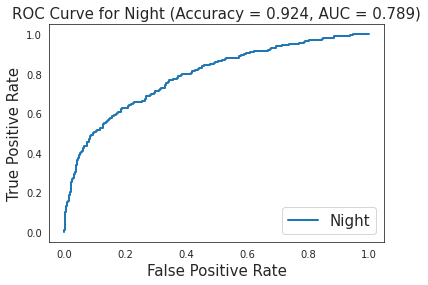

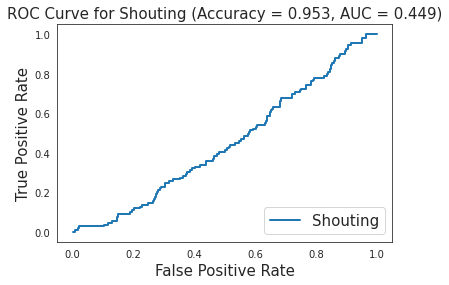

In [16]:
# plot ROC curve for protest
attr = "protest"
target = df_target[attr]
pred = df_pred[attr]
fig = plot_roc(attr, target, pred)
fig.savefig(os.path.join('files', attr+'.png'))
# plot ROC curves for visual attributes
for attr in df_pred.columns[3:]:
    target = df_target[attr]
    pred = df_pred[attr][target != '-']
    target = target[target != '-'].astype(int)
    fig = plot_roc(attr, target, pred)
    fig.savefig(os.path.join('files', attr+'.png'))

#### Violence

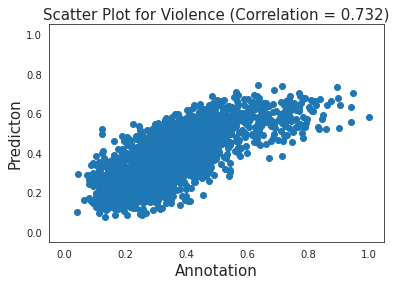

In [15]:
import scipy.stats as stats
attr = 'violence'
pred = df_pred[df_target['protest'] == 1][attr].tolist()
target = df_target[df_target['protest'] == 1][attr].astype(float).tolist()
fig, ax = plt.subplots()
plt.scatter(target, pred, label = attr.title())
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.xlabel('Annotation', fontsize = 15)
plt.ylabel('Predicton', fontsize = 15)
corr, pval = stats.pearsonr(target, pred)
plt.title(('Scatter Plot for {attr} (Correlation = {corr:.3f})'
            .format(attr = attr.title(), corr= corr)), fontsize = 15)
plt.show()
fig.savefig(os.path.join('files', attr+'.png'))